# Unraveling the SRAM Experiment: Tubeless vs. Tubular Tires — Are the Claims Inflated?
## Let’s delve into SRAM’s experiment with the Movistar cycling team. This article explores whether the methodology genuinely demonstrates the superiority of tubeless tires or if there is more to the story.

In the fast-paced world of cycling, innovation is the name of the game. With technology constantly evolving, riders and manufacturers are always on the hunt for that extra edge to gain a competitive advantage. One of the latest debates in the cycling world revolves around the choice between traditional tubular/tube tires and the newer tubeless systems. SRAM, the company behind ZIPP wheels, recently made waves by claiming that their tubeless system outperforms the traditional tubular setup. Their claims stem from a single, one-time test conducted in the demanding and brutal cobbled section of the Paris-Roubaix Trouée d’Arenberg. But, do these claims rest upon robust scientific methodology, or are they merely a case of pseudo-scientific testing designed to serve an ulterior motive as it can be pure marketing?

Note: You can find the SRAM’s article here: https://www.sram.com/es/life/stories/tubeless-at-trouee-darenberg

# Too Long; Didn’t Read (TL;DR)
SRAM claims tubeless tire superiority, but upon closer scrutiny, concerns arise. Their test, conducted with the Movistar cycling team, offers a limited view of the overall picture. Let’s break down the key issues:

1. SRAM’s experiment involved altering tire pressure between runs. This introduces a confounding variable, making it impossible to determine if the observed improvements are due to the tubeless system or simply changes in tire pressure. Controlled conditions, where the only variable is the tire type, are essential for drawing reliable conclusions.

2. There exists a probability of error between 34.9% and 84% (or even higher) in SRAM’s assertions.

3. Assuming that the unknown standard deviation falls within the lowest 98% of a real historical variability data and considering typical probabilities of making Type I and Type II errors (5% and 20%, respectively), the required number of rides per setup should exceed 28. If we aim for lower error rates (1% for Type I and 10% for Type II), the necessary number of rides per setup increases to 53.
In essence, while SRAM’s claims appear intriguing, the experiment’s limitations raise significant doubts. The need for controlled testing conditions, a larger quantity of data, and stringent statistical analysis is evident to draw concrete conclusions about the superiority of tubeless tires.

In the subsequent sections, we will explore the intricacies of the analysis, the statistical considerations, and the critical factors that influence the interpretation of these findings. This deeper exploration will shed light on the nuances and potential limitations of the data, providing a more comprehensive understanding of the evaluation process.

So, let’s venture further into the analytical terrain to uncover the full story behind the numbers.

IMPORTANT: It is crucial to clarify that this article does not attempt to prove that SRAM’s claims are wrong, suggesting there is no difference between the tubular setup and the tubeless system. This article emphasizes that there is not enough data to assert that tubuless tires are better than tubular tires. The article centers on the need for more robust data and controlled testing conditions to draw meaningful conclusions about the relative merits of these tire systems.



# Introduction

SRAM’s claims are rooted in a test conducted at the challenging cobbled Arenberg sector, complete with precise protocol specifications. These details involve the participation of riders A and B, baseline runs utilizing Zipp 303 Firecrest Tubular paired with Continental 30mm tubular tires, and subsequent runs employing Zipp 303 Firecrest Tubeless wheels fitted with Continental GP5000 S TR — 30mm tires at varying pressures. The parameters monitored encompassed time, power, and subjective evaluations concerning grip and comfort.

The reported facts by SRAM can be summarized as follows:

In the initial tubeless trial, Rider B managed to save 48 watts compared to tubular tires while maintaining a similar time.
On the second tubeless trial, Rider B achieved a 21-second time improvement with a power output approximately identical to the previous run.
Rider A showcased similar advantages by achieving faster times at the same wattage or maintaining the same times with a lower power output.
However, a pivotal error lies in extrapolating these specific results as universal truths and neglecting the consideration of intra-subject variability. Conducting multiple runs on the same segment and achieving precisely the same power and speed is, in fact, an impossibility. Variations in measurements are inevitable. The cause of these discrepancies resides in conditions influenced by uncontrollable variables such as wind, hand or foot positions, and the very nature of the road surface itself, particularly when it involves a challenging cobbled sector like the Forest of Arenberg.

As a concrete and real example, consider the real-world data (from my usual rides) collected on the same day (2023–03–08) for the same Strava segment ‘Rotonda Sant Fost — Rotonda intermitja’ near Barcelona (https://www.strava.com/segments/27164832). Notably, these trials were conducted using the same bike with same setup on the same day. What catches the eye is the remarkable consistency in mean power output: 179.5 watts and 179.8 watts, nearly identical. Nevertheless, a substantial disparity of 18 seconds persists in the results. This perplexing outcome underscores the undeniable influence of uncontrollable variables on our measurements.

In [1]:
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.stats.api as sms
from fitter import Fitter, get_common_distributions, get_distributions
from scipy.stats import beta

import warnings
warnings.filterwarnings('ignore')

In [2]:
SEGMENT_DATA_PATH = './data/all/'

# Read data

data = pd.DataFrame()


dfs = []
# Iterate over each file in the folder
for file_name in os.listdir(SEGMENT_DATA_PATH):
    # Check if the file is a CSV file
    if file_name.endswith('.csv'):
        # Construct the full path to the file
        file_path = os.path.join(SEGMENT_DATA_PATH, file_name)
        
        # Read the CSV file into a DataFrame
        df = pd.read_csv(file_path)
        
        # Append the DataFrame to the list
        dfs.append(df)

# Concatenate all the DataFrames into a single DataFrame
data_df = pd.concat(dfs, ignore_index=True)

## CLEAN DATA
# Remove activities without power meter or wrong measurements
data_df =data_df[data_df['Power Meter']==1]


# Remove activities done in group
data_df =data_df[data_df['Group Size']==1]

# Keep the days with more than 2 measure.
data_df = data_df.groupby(["When", "Name"]).filter(lambda x: len(x)>=2)

# Remove hour in the date
data_df['When'] = data_df['When'].apply(lambda d : d[:10] )

# Keep only Name, Date, Elapsed Time, Speed, Pace, Power
data_df = data_df[['Name', 'When', 'Elapsed Time', 'Speed km/h', 'Power (W)', 'Dist km', 'Gear']]

# The data is in SI units even if it said the opposite in the column name, so change it
data_df['Speed km/h'] = data_df['Speed km/h'] * 3.6
data_df['Dist km'] = data_df['Dist km'] / 1000

# Keep only segments between 2 and 3 kilometers
data_df = data_df[ (data_df['Dist km']>=2)  & (data_df['Dist km']<=3)]

# add a column with the Power to Speed ratio
data_df['Pw/Sp'] = data_df['Power (W)'] / data_df['Speed km/h']
data_df['Sp/Pw'] = data_df['Speed km/h'] / data_df['Power (W)']



In [3]:
data_df[data_df['When']=='2023-03-08'][data_df['Name']=='Rotonda Sant Fost - Rotonda intermitja']

,Name,When,Elapsed Time,Speed km/h,Power (W),Dist km,Gear,Pw/Sp,Sp/Pw
8050,Rotonda Sant Fost - Rotonda intermitja,2023-03-08,335,30.737552,179.8,2.8603,Clementina Gran touring G,5.849522,0.170954
8094,Rotonda Sant Fost - Rotonda intermitja,2023-03-08,353,29.170198,179.5,2.8603,Clementina Gran touring G,6.153541,0.162508


In essence, the enhancement claimed by SRAM might be attributed to the intra-subject variability caused by the interference of uncontrolled variables, as exemplified by the presented data.

Additionally, the conclusions are derived from a comparison between tubular and tubeless setups, where the tire pressures differ, potentially accounting for the observed variations. Consequently, while the genuineness of the reported facts are not questioned, they remain inadequate for reaching a conclusive verdict and in the sections that follow, we provide an extensive analysis of our arguments.

In [4]:
# Compute mean and variance grouped by 'When' and 'Name' columns
def std(x):
    return np.std(x, ddof=0)

grouped_stats = data_df.groupby(['When', 'Name', 'Gear']).agg(['mean', std, 'count']).drop([('Elapsed Time', 'count'), 
                                                                                                    ('Speed km/h', 'count'), 
                                                                                                    ('Power (W)', 'count'), 
                                                                                                    ('Pw/Sp', 'count'),
                                                                                                    ('Dist km',)], axis=1)

# Reset the index if needed
grouped_stats = grouped_stats.reset_index()

#Remove days with only one measure
grouped_stats = grouped_stats[grouped_stats[('Sp/Pw', 'count')]>1]

grouped_stats = grouped_stats.dropna()
grouped_stats

# pw_std/Speed_std the smallest the better
grouped_stats['ratio std'] = grouped_stats[('Power (W)', 'std')]/grouped_stats[('Speed km/h', 'std')]


grouped_stats = grouped_stats.sort_values(by='ratio std', ascending=True)

grouped_stats.head(10)


When                                               Name  \
                                                                     
165  2021-07-24                   Tram revirat St Bartomeu-La Roca   
358  2023-03-08             Rotonda Sant Fost - Rotonda intermitja   
244  2022-03-24                               2 Finals Vallensana.   
96   2021-06-02                 Ridemeeting Championship Sprint 32   
51   2021-03-18                 Ridemeeting Championship Sprint 32   
270  2022-05-20             Rotonda Sant Fost - Rotonda intermitja   
472  2023-06-29             Parc Fluvial del Besòs (Guipúscoa-B20)   
256  2022-04-05  [CTRA. LA ROCA INC.] De la rotonda de Montcada...   
162  2021-07-24                   RTDA EXPERIENCE / RTDA ST VICENÇ   
13   2021-01-21  [CTRA. LA ROCA INC.] De la rotonda de Montcada...   

                          Gear Elapsed Time       Speed km/h            \
                                       mean   std       mean       std   
165         Trek Madone 3.5           189.0  29.0  40.086640  6.150860   
358  Clementina Gran touring G        344.0   9.0  29.953875  0.783677   
244         Trek Madone 3.5           442.0   7.0  16.420770  0.260057   
96          Trek Madone 3.5           260.0   4.0  32.349503  0.497685   
51          Trek Madone 3.5           245.5   5.5  34.269257  0.767743   
270  Clementina Gran Touring R        293.0   9.0  35.176808  1.080516   
472                       NONE        260.5   3.5  35.467439  0.476530   
256         Trek Madone 3.5           256.5   5.5  32.330654  0.693250   
162         Trek Madone 3.5           290.0   8.0  31.522747  0.869593   
13          Trek Madone 3.5           281.0   3.0  29.501583  0.314964   

    Power (W)            Pw/Sp                 Sp/Pw                   \
         mean   std       mean       std        mean        std count   
165      0.45  0.15   0.012084  0.005596  105.342317  48.782683     2   
358    179.65  0.15   6.001532  0.152009    0.166731   0.004223     2   
244    244.65  0.05  14.902600  0.239059    0.067120   0.001077     2   
96     150.60  0.10   4.656554  0.074731    0.214806   0.003447     2   
51     182.50  0.20   5.328016  0.113529    0.187772   0.004001     2   
270    212.75  0.35   6.054037  0.195910    0.165352   0.005351     2   
472    180.10  0.20   5.078890  0.073877    0.196935   0.002865     2   
256    247.25  0.35   7.651291  0.174888    0.130765   0.002989     2   
162    155.55  0.55   4.937808  0.118768    0.202636   0.004874     2   
13     167.50  0.20   5.678381  0.067403    0.176131   0.002091     2   

    ratio std  
               
165  0.024387  
358  0.191405  
244  0.192265  
96   0.200930  
51   0.260504  
270  0.323919  
472  0.419701  
256  0.504868  
162  0.632480  
13   0.634994

# Understanding Intra-subject Variability and its Importance
To grasp the significance of intra-subject variability, it is essential to comprehend its essence. Intra-subject variability refers to the fluctuations observed within the same subject during multiple test runs. In our context, it signifies that even with the same rider and bike, variations in performance will occur due to uncontrollable factors. These factors might encompass the rider’s posture, muscle fatigue, minor deviations in tire pressure, or subtle variations in the road surface (particularly noticeable on a challenging cobble sector). The presence of these variables highlights the intricate web of influences that can lead to performance discrepancies.

To illustrate the impact of intra-subject variability, we turn to the wealth of data collected during countless hours of my training sessions on the La Roca Road. These sessions, meticulously prescribed by my trainer, Raul Celdran, primarily consist of extended series ridden at a consistent pace. As a result, I’ve amassed a comprehensive dataset on the Strava segments along my trainer road. This dataset serves as an excellent illustration of how uncontrollable factors can introduce variability into our results.

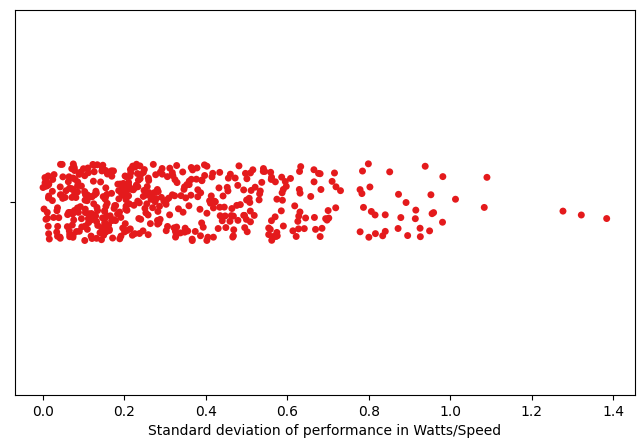

In [5]:
# Strip Plot for Univariate Visualization
plt.figure(figsize=(8, 5))
sns.stripplot(x=grouped_stats[('Pw/Sp', 'std')], palette="Set1", jitter=True)
#plt.title("Standard deviation distribution of my watts/speed ratio")
plt.xlabel("Standard deviation of performance in Watts/Speed")
plt.show()

In the provided graph, each data point signifies the variability, measured as the standard deviation, within a set of rides completed on the same day, along the same segment, using identical bike setups. The X-axis represents the standard deviation of the Power/Speed ratio measured, while the Y-axis is used merely to facilitate the distribution of data points for enhanced visual clarity.

To comprehend the standard deviation, consider this example: Suppose we have measurements for a specific day and segment, with a mean performance value of 5 watts per kilometer per hour (5 watts/(Km/h)) and a standard deviation of 0.7. This implies that, on average, for that particular day and segment, 5 watts are needed to maintain a speed of 1 kilometer per hour. The standard deviation of 0.7 reflects the average deviation of all measurements, from the mean. It quantifies the variability in performance, showing how results can diverge from the average under varying conditions. In other words, standard deviation can be seen as the average difference of a group of measurements with respect to its mean.

As depicted in the graph, the standard deviation in my data exhibits a range of variability, fluctuating from nearly zero (although never precisely 0) to 1.4 Watts per kilometer per hour (Watts/(Km/h)).

This distribution of standard deviations can be visualized more effectively through a histogram, which captures the frequency of different standard deviation values. Additionally, fitting the data to a Beta distribution allows us to model and understand the distribution of variability more comprehensively.

Text(0, 0.5, 'Frequency')

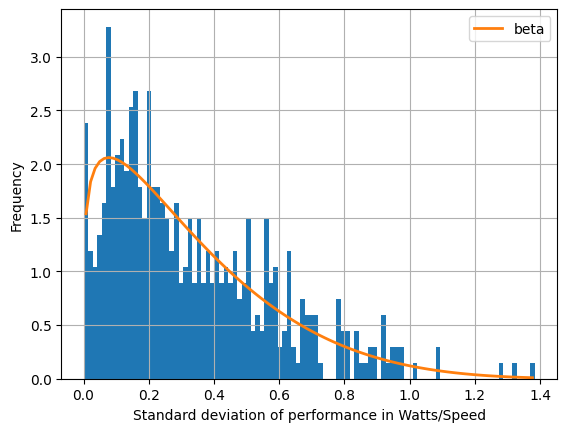

In [6]:
f = Fitter(grouped_stats[('Pw/Sp', 'std')],
           distributions=['beta'])
f.fit()
f.summary()
plt.xlabel('Standard deviation of performance in Watts/Speed')
plt.ylabel('Frequency')

In [7]:
param = f.get_best(method = 'sumsquare_error')
print(param)

{'beta': {'a': 1.1994272766598342, 'b': 5.654111551575711, 'loc': 0.0005549308175224502, 'scale': 1.8742923083584495}}


The fitted Beta distribution provides insight into the variability of standard deviations in my training data. This Beta distribution is characterized by the following parameters:

- Shape Parameter (a): 1.1994
- Shape Parameter (b): 5.6541
- Location Parameter (loc): 0.0006
- Scale Parameter (scale): 1.8743

In this dataset, the median of the standard deviation is approximately 0.27. This means that 50% of my training sessions exhibit a standard deviation greater than 0.27. It’s worth emphasizing that a standard deviation of 0.27 in the Watts/(Km/h) units is relatively high. To put this into perspective, let’s revisit the example of the ‘Rotonda Sant Fost — Rotonda intermitja’ segment on a specific day (2023–03–08). On that day, the standard deviation was only 0.15, which is relatively low. Even with this lower standard deviation and consistent power output, there was still a significant difference of 18 seconds in a segment that is less than 3 kilometers in length.

Moreover, it’s noteworthy that 98% of the standard deviation values in this dataset fall below 1, indicating that most of the data points have a standard deviation within this range.

This analysis emphasizes the need to account for intra-subject (intra-group) variations when evaluating cycling performance and making training and racing decisions, something SRAM didn’t do.

In [8]:
f.get_best(method = 'sumsquare_error')

{'beta': {'a': 1.1994272766598342,
  'b': 5.654111551575711,
  'loc': 0.0005549308175224502,
  'scale': 1.8742923083584495}}

In [9]:
probability_median = beta.cdf( 0.27,
    param['beta']['a'],
    param['beta']['b'],
    param['beta']['loc'],
    param['beta']['scale'] 
    )
probability_more_015 = 1-beta.cdf( 0.15,
    param['beta']['a'],
    param['beta']['b'],
    param['beta']['loc'],
    param['beta']['scale'] 
    )

probability_less_1 = beta.cdf( 1,
    param['beta']['a'],
    param['beta']['b'],
    param['beta']['loc'],
    param['beta']['scale'] 
    )

print(f'Probability of make a std lower than 0.27: {probability_median}')
print(f'Probability of make a std bigger than 0.15: {probability_more_015}')
print(f'Probability of make a std less than 1: {probability_less_1}')


Probability of make a std lower than 0.27: 0.5021593049537195
Probability of make a std bigger than 0.15: 0.7089318903118567
Probability of make a std less than 1: 0.9809097575208745


# Analysis of the SRAM data

Let’s start by visualizing the data collected by SRAM. The scatter plot below illustrates the performance of different setups in terms of ‘watts’ per kilometer per hour (watts/(km/h)).

In [10]:
# Data from https://www.sram.com/es/life/stories/tubeless-at-trouee-darenberg

# The Trouée d'Arenberg or Tranchée de Wallers-Arenberg (English: Trench of Arenberg) is a 2.3 km long cobbled road in the municipality of Wallers in Northern France, in the Département Nord.
# What sram says is true, but it is indicative of a real difference?
sram_data ={ 'rider': ['rider A', 'rider A','rider A','rider A','rider A', 'rider B', 'rider B', 'rider B', 'rider B', 'rider B'],
             'setup' : ['tubular', 'tubeless', 'tubeless', 'tubeless', 'tubeless', 'tubular', 'tubeless', 'tubeless', 'tubeless', 'tubeless'],
             'time': [243, 247, 230, 233, 230, 257, 255, 238, None, None],
             'watts': [390, 347, 376, 397, 394, 271, 223, 275, None, None],
             'pressure': [4.5, 5, 4.5, 4, 3.5, 4.5, 5, 4.5, 4, 3.5 ]}

sram_df = pd.DataFrame.from_dict(sram_data)

# Explicar porque aqui usamos watts*time y en mi comparativa usamos watts/speed. En la tablet está la respuesta
sram_df['performance']=sram_df['watts']*sram_df['time']

lenght_arenberg = 2300 #meters
sram_df['Speed km/h'] = (lenght_arenberg/sram_df['time']) * 3.6


# add a column with the Power to Speed ratio
sram_df['watts_per_kph'] = sram_df['watts'] / sram_df['Speed km/h']

sram_df

,rider,setup,time,watts,pressure,performance,Speed km/h,watts_per_kph
0,rider A,tubular,243.0,390.0,4.5,94770.0,34.074074,11.445652
1,rider A,tubeless,247.0,347.0,5.0,85709.0,33.522267,10.351329
2,rider A,tubeless,230.0,376.0,4.5,86480.0,36.000000,10.444444
3,rider A,tubeless,233.0,397.0,4.0,92501.0,35.536481,11.171618
4,rider A,tubeless,230.0,394.0,3.5,90620.0,36.000000,10.944444
5,rider B,tubular,257.0,271.0,4.5,69647.0,32.217899,8.411473
6,rider B,tubeless,255.0,223.0,5.0,56865.0,32.470588,6.867754
7,rider B,tubeless,238.0,275.0,4.5,65450.0,34.789916,7.904589
8,rider B,tubeless,NaN,NaN,4.0,NaN,NaN,NaN
9,rider B,tubeless,NaN,NaN,3.5,NaN,NaN,NaN


Text(0.5, 1.0, 'Relationship between setup, pressure and performance for each rider')

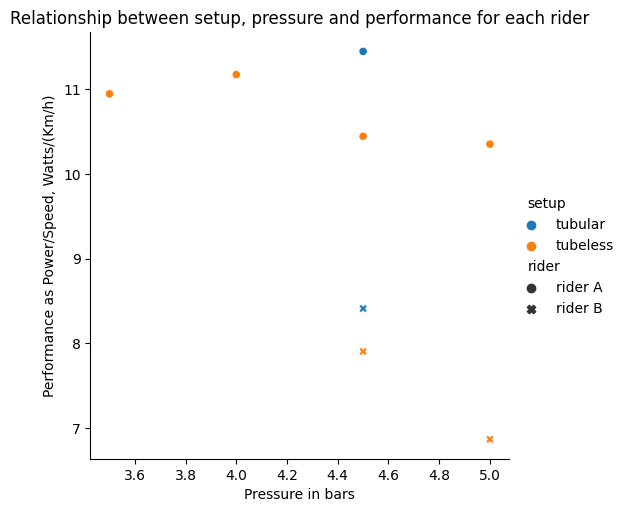

In [11]:
#Graphical representation of the columns for ‘pressure’ and ‘watts_per_kmh’. Blue indicates the tubular setup, while orange represents the tubeless setup. Circles denote rider A, while crosses represent rider B.
sns.relplot(x='pressure', y='watts_per_kph', data=sram_df, hue='setup', style='rider')
plt.xlabel('Pressure in bars')
plt.ylabel("Performance as Power/Speed, Watts/(Km/h)")
plt.title("Relationship between setup, pressure and performance for each rider")

The graph clearly illustrates that rides conducted with the tubeless system consistently outperform those executed with the tubular setup, but in SRAM’s test, a detailed study of variability is absent, and the only directly comparable values are those recorded at a tire pressure of 4.5 bars, which is the sole pressure setting with values for both setups.

There is a 52% probability of detecting a (spurious) difference for rider B that, in reality, does not exist.

When considering the 4.5-bar pressure scenario, we observe that the tubeless system outperforms the tubular by 1 Watt per kilometer/hour for rider A and 0.51 Watts per kilometer/hour for rider B. To provide context, when I analyze my own data — where I use the same bike and setup, measured on the same segment — I find that I encounter the same difference as rider A about 22% of the time, the same difference as rider B approximately 52% of the time, and the same difference as the average observed by riders A and B around 34.9% of the time.

This means that, when considering my own data, due to my intra-subject variability, I observe differences equivalent to those of rider A, rider B, and the mean of both riders the 22%, 52%, and 34.9% of the time, respectively and it’s crucial to understand that in reality, there is no such difference. These percentages are calculated based on the cumulative distribution function of the previously computed Beta function.

In conclusion, the data presented by SRAM indeed indicates a noticeable gap between measurements. However, we must interpret these findings cautiously. Real-world data, including my own observations, reflects similar differences, but it’s crucial to acknowledge that these disparities likely stem from uncontrolled and hide factors rather than an actual difference. This is evident because all rides were conducted with the same bike, on the same segment, during the same training session.

Note: The assumption that the variability of these Movistar cyclists on the highly demanding cobble section of the Trouée d’Arenberg is similar to my variability measured on a perfect tarmac provides an advantage to SRAM’s claims. The cobble section poses significantly greater challenges and introduces more uncontrolled variables, likely resulting in higher variability. This, in turn, makes the earlier numbers an overly optimistic estimation of the error, implying that there is even a higher probability of SRAM making an error in their conclusions, as it is shown in the next paragraph.



In [12]:
#the difference between the two measurements is 1, so the standard deviation os 0.5
probability_more_05 = 1-beta.cdf( 0.5,
    param['beta']['a'],
    param['beta']['b'],
    param['beta']['loc'],
    param['beta']['scale'] 
    )

#the difference between the two measurements is 0.51, so the standard deviation os 0.255
probability_more_0255 = 1-beta.cdf(0.255,
    param['beta']['a'],
    param['beta']['b'],
    param['beta']['loc'],
    param['beta']['scale'] 
    )

# Mean value of the two riders
#the mean value of the two differences is 0.755
probability_more_mean = 1-beta.cdf(0.3775,
    param['beta']['a'],
    param['beta']['b'],
    param['beta']['loc'],
    param['beta']['scale'] 
    )

 
print(f'Probability of make a std more than 0.3775: {probability_more_mean}')

#Rider A, 1 is the difference in the values for 4.5 bars, i.e. std= 1/2 
print(f'Probability of make a std more than 0.5: {probability_more_05}')

#Rider B, 0.51 is the difference in the values for 4.5 bars, i.e. std = 0.51/2
print(f'Probability of make a std more than 0.255: {probability_more_0255}')


Probability of make a std more than 0.3775: 0.34911663478210575
Probability of make a std more than 0.5: 0.22305059979476916
Probability of make a std more than 0.255: 0.5216511969838034


From other approach, we can conclude that if the difference between the tubular and tubeless systems doesn’t actually exist, there’s an 84% probability that SRAM is making a mistake in its claims.

Now, let’s approach the data from a different perspective, and, even though it’s incorrect due to the non-weighted-normalized power data and the variations in tire pressures, let’s take a step that favors SRAM’s claims. Let’s categorize the data into two groups without distinguishing between the riders: the control group, which includes all tubular measurements (only 2 in total), and the treatment group, consisting of all tubeless measurements (6 in total). When we conduct an A/B test under these circumstances, the resulting p-value is 0.84. This implies that if there’s actually no difference between the tubular and tubeless systems, there’s an 84% probability that SRAM has made an error in its claims.

Note: If you have reservations about utilizing the variability of my data as a reference, the recommended course of action is to estimate their own variability through a series of repeated rides, as I elaborate in the following section. In essence, regardless of the chosen approach, a significantly larger number of rides should have been carried out.



In [13]:
df_control = sram_df[sram_df['setup']=='tubular']
df_treat = sram_df[sram_df['setup']=='tubeless'].dropna()

t_statistic, pval = stats.ttest_ind(df_control['watts_per_kph'], df_treat['watts_per_kph'])

print(pval)

0.8417936710527993


How should have been conducted a simple A/B test
The experiment’s goal is to assess the performance of two distinct bike setups (tubeless vs. tubular) under specific conditions using a defined metric. To achieve this, one potential approach is to execute a straightforward A/B test:

Step 1: Metric Selection

The first step in conducting an A/B test is to select a metric for comparison. This choice significantly influences the design of the test parameters. For instance, we can opt for either the time required to complete a segment or a power-to-speed metric:

Time to complete a segment: This metric offers straightforward interpretation but doesn’t permit the mixing of measurements from different cyclists.
Power-to-weight ratio per kilometer per hour (‘(watts/kg)/(km/h)’): This more complex metric involves calculating the rider’s power-to-weight ratio (in watts per kilogram) divided by speed (in kilometers per hour). It allows for the comparison of rides with varying power outputs among different cyclists.
Step 2: Establish the Minimum Effect

Define the minimum effect (minimum difference in means of the chosen metric) that justifies a move to the treatment group setup. For instance, if the chosen metric is time, an improvement of 3 to 5 seconds might be selected, as it represents the minimum gap time required to a cyclist being dropped from a group.

Step 3: Establish the Level of Significance and Power

In this critical step, we need to set the level of significance and determine the statistical power for our A/B test. These two parameters play pivotal roles in the design and interpretation of our experiment. Let’s define them:

Level of Significance: In the world of statistical hypothesis testing, the level of significance, denoted as alpha (α), is a crucial factor that helps us control the likelihood of making a Type I error. A Type I error occurs when we incorrectly reject the null hypothesis, in our case when we say that there is a difference in performance between tubular setting and tubeless when in fact the performance it’s the same. In simpler terms, it’s the probability of detecting an effect that doesn’t exist.
typical values are 0.5, and choosing a lower alpha (e.g., α = 0.01) reduces the risk of Type I errors, but it may also require a larger sample size to detect real effects. In our case, selecting an alpha value is essential to determine the threshold for statistical significance.
Statistical Power: Statistical power is related to the probability of correctly rejecting a null hypothesis when it is indeed false. In other words, it’s the probability of detecting a real effect. High statistical power (typically 0.8 or higher) implies that the test is effective in distinguishing actual differences or effects. On the other hand, low power increases the risk of Type II errors, where we fail to detect real effects.
These parameters enable us to balance the risk of making erroneous conclusions (Type I and Type II errors) with the ability to detect true differences in bike setups. Properly configuring the level of significance and statistical power enhances the reliability and credibility of our A/B test results.

Step 4: Determine the Required Number of Repetitions

Calculate the number of repeated rides necessary. This number relies on the minimum effect we want to detect, intra-subject standard deviation, power, and significance level. It’s essential to normalize the effect by the standard deviation. In cases where prior variability data is unavailable, conduct additional rides and calculate power and the standard deviation as you go.

For example, a graph illustrating the number of required rides (per group) is displayed, depending on intra-subject variability (if the rides are conducted by a single cyclist) or intra-group variability (if several cyclists participate in the same group), and the effect to be detected.

In [14]:
grouped_stats[grouped_stats[('When',)]=='2023-03-08'][grouped_stats['Name']=='Rotonda Sant Fost - Rotonda intermitja']

When                                    Name  \
                                                          
358  2023-03-08  Rotonda Sant Fost - Rotonda intermitja   

                          Gear Elapsed Time      Speed km/h            \
                                       mean  std       mean       std   
358  Clementina Gran touring G        344.0  9.0  29.953875  0.783677   

    Power (W)           Pw/Sp               Sp/Pw                 ratio std  
         mean   std      mean       std      mean       std count            
358    179.65  0.15  6.001532  0.152009  0.166731  0.004223     2  0.191405

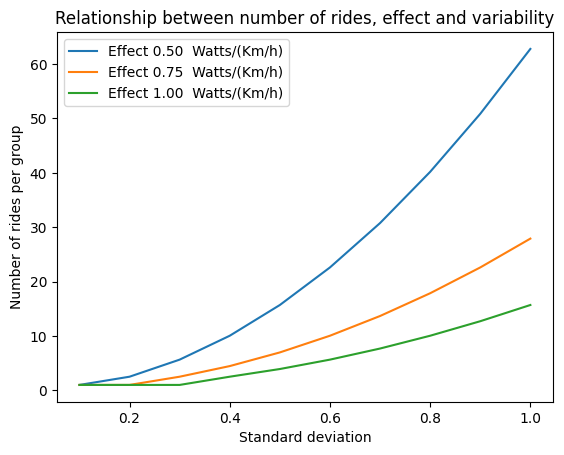

In [15]:
ratio_std_domain = np.linspace(0.1, 1, 10).tolist()

effect_domain = np.linspace(0.5,1, 3).tolist()


for i,e in enumerate(effect_domain):
    n_samples_lst=[]
    for j,r_std in enumerate(ratio_std_domain):
        norm_e = e / r_std
        n_samples = sms.NormalIndPower().solve_power( 
                    effect_size=norm_e, 
                    power=0.8,
                    alpha=0.05, 
                    ratio=1
                    )
        if  isinstance(n_samples, np.ndarray):
            n_samples=1

        #n_samples_map[i, j] = n_samples
        n_samples_lst.append(n_samples)

    plt.plot(ratio_std_domain, n_samples_lst, label=f'Effect {e:.2f}  Watts/(Km/h)')

plt.xlabel('Standard deviation')
plt.ylabel('Number of rides per group')
plt.title('Relationship between number of rides, effect and variability')
plt.legend(loc="best")

        

#sns.heatmap(n_samples_map, annot=False, cmap="coolwarm")
    

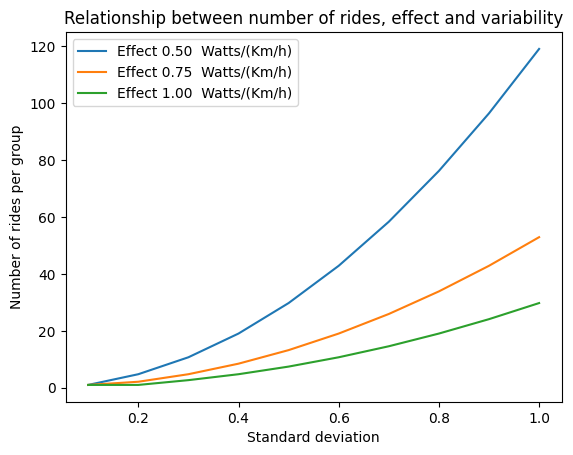

In [16]:
ratio_std_domain = np.linspace(0.1, 1, 10).tolist()

effect_domain = np.linspace(0.5,1, 3).tolist()


for i,e in enumerate(effect_domain):
    n_samples_lst=[]
    for j,r_std in enumerate(ratio_std_domain):
        norm_e = e / r_std
        n_samples = sms.NormalIndPower().solve_power( 
                    effect_size=norm_e, 
                    power=0.9,
                    alpha=0.01, 
                    ratio=1
                    )
        if  isinstance(n_samples, np.ndarray):
            n_samples=1

        #n_samples_map[i, j] = n_samples
        n_samples_lst.append(n_samples)

    plt.plot(ratio_std_domain, n_samples_lst, label=f'Effect {e:.2f}  Watts/(Km/h)')

plt.xlabel('Standard deviation')
plt.ylabel('Number of rides per group')
plt.title('Relationship between number of rides, effect and variability')
plt.legend(loc="best")

        

#sns.heatmap(n_samples_map, annot=False, cmap="coolwarm")
    

These two graphs illustrate the relationship between various factors for the data provided by SRAM:

For Rider B’s effect (0.51) and a variability of 1 or less (encompassing 98% of my variability values), if we aim for a significance level of 5% and a power of 0.8, the required number of repetitions per setup exceeds 60. Opting for a lower probability of Type I and II errors with a significance level of 1% and a power of 0.9, the number of rides increases to 115.
For the effect of the average of Rider A and Rider B (0.75) and a variability of 1 or less (encompassing 98% of my variability values), the number of needed repetitions per group, with a significance level of 5% and a power of 0.8, is more than 28. Reducing the probability of Type I and II errors with a significance level of 1% and a power of 0.9 elevates the number of rides to 53.
For the effect of the average of Rider A (1) and a variability of 1 or less (encompassing 98% of my variability values), the required number of repetitions per group is more than 16 at a significance level of 5% and a power of 0.8. Choosing a lower probability of Type I and II errors with a significance level of 1% and a power of 0.9 increases the number of rides to 30.
Step 5: Repeat the Rides

Repeat the rides while ensuring consistent testing conditions. Factors like tire pressure, terrain, rider weight, and bike setup should remain consistent. If variations in factors like tire pressure are of interest, design separate A/B tests to explore those variables individually. More advanced tests may be performed to assess the impact of varying multiple variables simultaneously.

Step 6: Perform the A/B test

Using the available data, we conducted the A/B test. If the obtained p-value is greater than the chosen significance level, it suggests that there isn’t enough evidence to conclude that the measurements from the two setups are different. Conversely, if the p-value is lower than the significance level, we can claim that there exists a difference between the two setups knowing that exists a probability given by the size of the p-value. e.g., if the p-value is 0.04, we have a probability of 4% of making a mistake claiming that there exists a difference if in reality there is no exists such difference.

In [17]:
#norm_e = 0.3/0.27
norm_e = 0.51/1
n_samples = sms.NormalIndPower().solve_power( 
                    effect_size=norm_e, 
                    power=0.9,
                    alpha=0.01, 
                    #alpha=0.01, 
                    ratio=1
                    )

print(n_samples)

114.41281941133546


# Conclusions
SRAM promotes the superiority of tubeless tires, but upon closer examination, concerns emerge. Their test, conducted in collaboration with the Movistar cycling team, provides only a limited perspective of the broader picture. Let’s delve into the essential findings:

Pressure Variability: One glaring issue is the variation in tire pressure. SRAM’s experiment involved changing tire pressure between runs. This introduces a confounding variable, making it impossible to determine if the observed improvements are due to the tubeless system or merely changes in tire pressure. Controlled conditions, where the only variable is the tire type, are crucial for reliable conclusions.
Variability caused by uncontrolled variables: Variability caused by uncontrolled variables refers to fluctuations or differences in data that arise due to factors or elements in an experiment that are not intentionally controlled or manipulated. These uncontrolled variables can introduce noise or random variation into the data, making it challenging to attribute observed differences or effects solely to the variables being studied. To put this into perspective, consider a personal experience. In rides using the same bike and setup on a well-maintained tarmac, approximately 52% of the time, there’s a similar variation in performance as observed in SRAM’s test with Rider B. This suggests that the majority of the observed variation could be attributed to uncontrollable factors rather than the tire setup.
Limited Comparative Data: When it comes to making meaningful comparisons, the only feasible option is to consider the data collected at 4.5 bar of tire pressure. However, this leaves us with only one measurement per setup. Additionally, weight information for the riders is unavailable, making it challenging to normalize the effort based on power. Even when we set aside the issue of tire pressure variation and combine data from both riders to perform an A/B test, the resulting p-value is 0.84. This implies that if there is no actual difference between the two setups, there is an 84% chance of making a Type I error, indicating a significant risk of drawing incorrect conclusions.
Data Quantity and Statistical Significance: To establish meaningful statistical significance, the number of data points becomes crucial. Assuming that the unknown standard deviation falls within the lowest 98% of my historical (variability) data and considering typical probabilities of making Type I and Type II errors (5% and 20%, respectively), the number of rides needed per setup should exceed 28. If we aim for lower error rates (1% for Type I and 10% for Type II), the required number of rides per setup increases to 53.
In essence, while SRAM’s claims may seem intriguing, the limitations of the experiment raise significant doubts. It is clear that controlled testing conditions, a more substantial dataset, and rigorous statistical analysis are essential to draw definitive conclusions regarding the superiority of tubeless tires.

